In [5]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from scipy.signal import find_peaks, peak_prominences
import scipy.signal
%matplotlib notebook


def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return result

######### define FFT function first ###########

def process_gaussian_fft(t,data_t,sigma_gauss):
    nfft = len(data_t) # number of points
    dt = t[1]-t[0]  # time interval
    maxf = 1/dt     # maximum frequency
    df = 1/np.max(t)   # frequency interval
    f_fft = np.arange(-maxf/2,maxf/2+df,df)          # define frequency domain

    ## DO FFT
    data_f = np.fft.fftshift(np.fft.fft(data_t)) # FFT of data

    ## GAUSSIAN FILTER
#    sigma_gauss = 25  # width of gaussian - defined in the function
    gauss_filter = np.exp(-(f_fft)**2/sigma_gauss**2)   # gaussian filter used
    data_f_filtered= data_f*gauss_filter    # gaussian filter spectrum in frquency domain
    data_t_filtered = np.fft.ifft(np.fft.ifftshift(data_f_filtered))    # bring filtered signal in time domain
    return data_t_filtered

# Feature extraction for Random forest
def extract_features(data):

    # "data" needs to already be normalized
    peaksIndexes = [np.argmax(data), np.argmin(data)]

    # indexes of peak and trough (in the order they occur)
    peaksIndexes = [min(peaksIndexes), max(peaksIndexes)]

    # Normalise data
    absData = np.abs(data) / max(data)

    area = calculate_signed_area(absData)

    max_min_ratio = np.abs(np.max(data) / np.min(data))

    widths = scipy.signal.peak_widths(absData, peaksIndexes)
    width1 = widths[0][0]
    width2 = widths[0][1]

    return np.array([area, max_min_ratio, width1, width2])


def calculate_signed_area(array):
    signed_area = np.trapz(array, dx=1)
    return signed_area


In [ ]:
from pynput.keyboard import Controller, Key
import time

keyboard = Controller()

# Function to simulate key press
def simulate_key_press(key):
    keyboard.press(key)
    time.sleep(0.2)  # This is to ensure that the keypress is registered 
    keyboard.release(key)

def press_two_keys(key1, key2):
    """
    Presses two keys simultaneously.
    
    Args:
    key1: The first key to press. Can be a character like 'a' or a special key like Key.ctrl.
    key2: The second key to press. Can be a character like 'b' or a special key like Key.alt.
    """
    keyboard = Controller()
    
    # Press both keys
    keyboard.press(key1)
    keyboard.press(key2)

    # Release both keys
    keyboard.release(key1)
    keyboard.release(key2)

# Read the file and press keys based on specific words
def read_and_press_keys(label):
    if label == "DoubleBlink": 
        simulate_key_press(Key.space)  # Simulate space bar press
        print("Pause")
    elif label == "Right":
        press_two_keys(Key.cmd, Key.right)  # Simulate F9 key press
        print("Skip song")
    elif label == "Left": 
        press_two_keys(Key.cmd, Key.left) # Simulate F8 key press 
        press_two_keys(Key.cmd, Key.left) # Go back a song, not just to start of current song 
        print("Previous song") 
    else:
        print('Do nothing')


In [9]:
# use this to find ports
from serial.tools import list_ports

ports = list_ports.comports()
for port in ports:
    print(port)

/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbserial-DM7WHRHQ - Heart and Brain SpikerBox


In [10]:
# Read data
baudrate = 230400
# cport = 'COM9'  # set the correct port before you run it
# cport = '/dev/tty.usbmodem141101'  # set the correct port before run it
cport = "/dev/cu.usbserial-DM7WHRHQ"
ser = serial.Serial(port=cport, baudrate=baudrate)    # this initializes the animated plot
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


<IPython.core.display.Javascript object>

In [ ]:
# Random forest training

import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# reading in all the eye movement files
# storing them as a dataframe with two columns: label and data
# label is the eye movement type (ex: up)
# data is a list of the numbers that were within the file 

# whoever is running the code will need to change this 

main_folder = '/Users/jameslocke/Documents/SpikerStream-master-2/Model training/finalTrainingExamples'


data = []


# iterating over each folder in the main folder

for folder_name in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder_name)
    
    # if the item is a folder
    
    if os.path.isdir(folder_path):
        
        # iterate over each file in that folder 
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # if the item is a file 
            
            if os.path.isfile(file_path):
                
                # store the file content as a list 
                
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        numbers = file.read().splitlines()
                        nump_array = np.array(list(np.float_(numbers)))
                        features=  extract_features(nump_array)
                        numbers = list(features)
                        numbers = list(map(str, numbers))
                except UnicodeDecodeError:
                    continue
                
                # creating a dictionary 
                # with the folder name as the label and file contents as the data 
                
                # data.append({'Label': folder_name, 'Data': numbers})
                data.append({'Label': folder_name, 'Data': features})

# making into a dataframe 

df = pd.DataFrame(data)

# checking the output 

print(df.head())
print()
print(df['Label'])

def train_random_forest(dataframe):

    X = pd.DataFrame(dataframe['Data'].values.tolist())
    y = dataframe['Label']
    print(X)
    
    # handling missing 
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    # splitting the data into training and testing sets 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    clf = RandomForestClassifier()
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    return clf, scaler

outputs = train_random_forest(df)
trained_classifier = outputs[0]
scaler = outputs[1]

In [11]:
# Random Forest classifier for a file
def classify_eye_movement(file_path, classifier, scaler):

    # reading in the file 
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            numbers = file.read().splitlines()
            nump_array = np.array(list(np.float_(numbers)))
            features=  extract_features(nump_array)
            # numbers = list(features)
            # numbers = list(map(str, numbers))

    except UnicodeDecodeError:
        print("Unable to read the file due to encoding issues.")
        return None
        
    # converting the numbers to float values 
    
    try:
        numbers = [float(num) for num in numbers]

    except ValueError:
        print("Error converting string data to float values.")
        return None
    
    # converting to a numpy array with a single row 
        
    X = np.array([features])
    X_scaled = scaler.transform(X)

    # Predict the label
    predicted_label = classifier.predict(X_scaled)[0]

    
    # predicted_label = classifier.predict(X)[0]
    
    return predicted_label

# Live classifier
def live_classify(normalised_event, classifier, scaler):
    features = extract_features(normalised_event)

    X = np.array([features])
    X_scaled = scaler.transform(X)

    # Predict the label
    predicted_label = classifier.predict(X_scaled)[0]

    return predicted_label

# Blink vs double blink
def distinguish_signal(signal, significance_threshold = 0.5):
    # Find peaks in the signal
    peaks, _ = find_peaks(signal, prominence=(None, None))

    # If there are at least two peaks
    if len(peaks) >= 2:
        # Sort peaks by prominence (peak height)
        sorted_peaks = sorted(peaks, key=lambda x: signal[x], reverse=True)
        first_peak = sorted_peaks[0]
        second_peak = sorted_peaks[1]

        # Check if the second peak is significant compared to the first peak
        significance = signal[second_peak] / signal[first_peak]
        
        if significance > significance_threshold:
            return "Type 2 Signal"  # Second peak significant
        else:
            return "Type 1 Signal"  # Second peak not significant
    else:
        return "Unknown"

In [16]:
# Calibration - 1

import numpy as np

# Firstly, take 20s of data to calculate the noise mean. This is now stored in data_plot_filtered

# numpy array of calibration data
data = np.abs(data_plot_filtered) 

# Calculate reduced data where deviations from the mean are less than one standard deviation
mean_data = np.mean(data)
std_data = np.std(data)
reduced = data[np.abs(data - mean_data) < 1 * std_data]

# Calculate the mean of the reduced data
redAve = np.mean(reduced)

# The mean of the noise - to be used when centering event waveforms around 0
noiseMean = redAve

print(noiseMean)

508.36378526420134


In [ ]:
# Calibration - 2

# Secondly, take 30s of data with a certain sequence of events

# Events are all normalised
Vpp = []

i = 0
while i < event_count:
    currentEvent = events[i]
    Voltage_pp = max(currentEvent) - min(currentEvent)
    if Voltage_pp > 30:
        Vpp.append(Voltage_pp)
        print(Voltage_pp)
    i += 1

aveVpp = sum(Vpp) / len(Vpp)

# Find the minimum Vpp to not be considered a false positive
if min(Vpp) < aveVpp:
    minimum_Vpp = min(Vpp) / 2
else:
    minimum_Vpp = aveVpp / 2

print(minimum_Vpp)


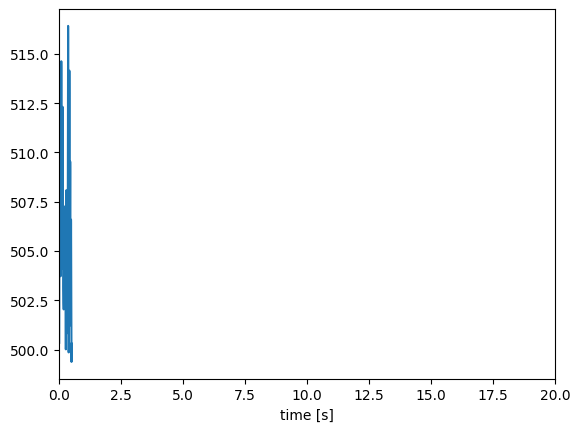

KeyboardInterrupt: 

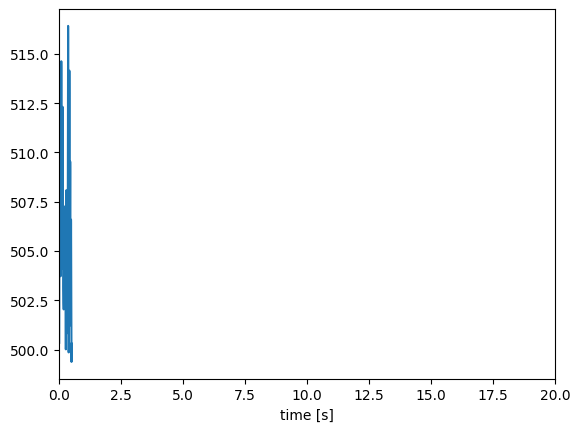

In [59]:
# take continuous data stream 
inputBufferSize = 10000 # keep betweein 2000-20000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
# ser.set_buffer_size(rx_size = inputBufferSize)

%matplotlib inline

total_time = 60.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 20; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
# fig.show()
fig.canvas.draw()

# event detection variables

event = 0  # 1 if an event is happening at this time step.
events = []
event_count = 0

event_ended = 0

upThreshold = 10
# downThreshold = 5
downThreshold = 8

gone_up = False
just_under = False

# an arbitrary initial value for calibration
# noiseMean = 500 


from IPython.display import clear_output, display

for k in range(0,int(N_loops)):
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    
    # DO THE GAUSSIAN FILTERING FIRST - OTHERWISE YOUR CODE SLOWS DOWN
    # define temporary time array OF THE WINDOW
    T = inputBufferSize/20000.0*np.linspace(0,1,(data_temp).size)
    sigma_gauss = 25
    data_temp_filtered = process_gaussian_fft(T,data_temp,sigma_gauss)

    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
            data_plot_filtered = data_temp_filtered
        else:
            data_plot = np.append(data_temp,data_plot)
            data_plot_filtered = np.append(data_temp_filtered,data_plot_filtered)

        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
        
        data_plot_filtered = np.roll(data_plot_filtered,len(data_temp_filtered))
        data_plot_filtered[0:len(data_temp_filtered)] = data_temp_filtered
        
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    t_filtered = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot_filtered).size)
        
    t_filtered = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot_filtered).size)

    # same thing here
    
    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    ax1.plot(t_filtered,data_plot_filtered)

    clear_output(wait=True)
    display(fig)

    # event detection

    data = np.abs(data_temp_filtered)
    sd = np.std(data)

    if event == 0:
        if sd > upThreshold:  # new event
            event_count += 1
            event = 1
            new_event = data
            events.append(new_event)
            print("new event")
    else:
        if sd <= downThreshold:
            event = 0
            
            current_event = events[event_count - 1]
            normalised_event = current_event - noiseMean
            events[event_count - 1] = normalised_event

            # Consider filtering out events that are too short or not large enough in ampltiude. 
            # Possible idea: if event's maximum value isn't more that 2 SD's away from the event's mean, then it's no longer an event.

            # Use calibration to set a reasonable value for this peak to peak voltage. E.g. get user to look right several times, then left
            # several times. Take the average of these peak to peak voltages, and set the threshold to be half. Or, just set the threshold
            # to be half of the minimum Vpp that we observe during calibration. Should definitely take a combination of all possible 
            # movements to be used, i.e. take blinks as well (probably don't need to worry about double blinks)
            minimum_Vpp = 50

            if len(normalised_event) < 4000 or (max(normalised_event) - min(normalised_event) < minimum_Vpp):
                print('non event')
            else:
                
                # Random forest
                event_type = live_classify(normalised_event, trained_classifier, scaler)
                
                print(event_type)

                # determine using max/min if event is left or right (and give the correct label)
                # Also need a way to distinguish between single and double blink.

                if event_type == "Left" or event_type == "Right":
                    peak_index = np.argmax(data)
                    trough_index = np.argmax(data)

                    if peak_index < trough_index:
                        label = "Left" 
                    else:
                        label = "Right"
                else:
                    label = event_type

                read_and_press_keys(event_type)

        else:
            current_event = events[event_count - 1]
            current_event = np.concatenate((current_event, data))
            events[event_count - 1] = current_event
                
    prev_sd = sd

# absArray = np.abs(data_plot_filtered)
# combined_array = np.column_stack((t_filtered, absArray))
# path = '/Users/jameslocke/Documents/SpikerStream-master-2/Week 12 data/lookRightTest.txt'

# # Save the combined array to a CSV file
# np.savetxt(path, combined_array, delimiter=',')

# i = 0
# while i < event_count:
#     currentEvent = events[i]
#     path = '/Users/jameslocke/Documents/SpikerStream-master-2/Week 12 data/Events/event_number' + str(i) + '.txt'
#     np.savetxt(path, currentEvent)
#     i += 1


In [ ]:
def freq_fft(t,data_t):
    nfft = len(data_t) # number of points
    dt = t[1]-t[0]  # time interval
    maxf = 1/dt     # maximum frequency
    df = 1/np.max(t)   # frequency interval
    f_fft = np.arange(-maxf/2,maxf/2+df,df)          # define frequency domain

    ## DO FFT
    data_f = np.fft.fftshift(np.fft.fft(data_t)) # FFT of data

    return f_fft, data_f

In [ ]:
# close serial port if necessary
if ser.read():
    ser.flushInput()
    ser.flushOutput()
    ser.close()